In [1]:
import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
import os
import IPython.display as ipd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/cremad.zip

Archive:  /content/drive/MyDrive/cremad.zip
replace AudioWAV/1001_DFA_ANG_XX.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
label_dict = { 'ANG':0, 'DIS':1, 'FEA':2, 'HAP':3, 'NEU':4, 'SAD':5 }

def get_label_from_audio_filename(f):
  for val in label_dict.keys():
    if val in f:
      return label_dict[val]
  return float('nan')

text_ids = ['WSI', 'TSI', 'IEO', 'TIE', 'DFA', 'IOM', 'MTI', 'IWL', 'IWW', 'ITH', 'ITS', 'TAI']

def get_text_id_from_audio_filename(f):
  for val in text_ids:
    if val in f:
      return val
  return float('nan')

speaker_ids = ['1070', '1007', '1056', '1006', '1084', '1072', '1038', '1020', '1057', '1035', '1059', '1041', '1042', '1079', '1015', '1023', '1048', '1024', '1065', '1025', '1018', '1085', '1009', '1014', '1073', '1029', '1090', '1022', '1062', '1021', '1047', '1083', '1055', '1077', '1064', '1089', '1050', '1051', '1036', '1001', '1066', '1088', '1008', '1026', '1012', '1039', '1028', '1010', '1067', '1011', '1043', '1071', '1060', '1031', '1091', '1058', '1034', '1053', '1049', '1075', '1017', '1040', '1068', '1074', '1037', '1082', '1003', '1019', '1032', '1005', '1080', '1061', '1004', '1087', '1081', '1027', '1013', '1030', '1054', '1063', '1046', '1044', '1052', '1078', '1033', '1016', '1076', '1086', '1002', '1069', '1045']

def get_speaker_id_from_audio_filename(f):
  for val in speaker_ids:
    if val in f:
      return val
  return float('nan')


In [5]:
data_folder = "AudioWAV/"
filepaths   = [data_folder + val for val in os.listdir(data_folder)]
labels      = [get_label_from_audio_filename(p) for p in filepaths]
text_ids = [get_text_id_from_audio_filename(p) for p in filepaths]
speaker_ids = [int(get_speaker_id_from_audio_filename(p)) for p in filepaths]
data = pd.DataFrame(zip(filepaths,labels,text_ids,speaker_ids),columns=['AudioPath','Emotion','Text_Id','Speaker_Id'])
display(data.head())
print("Number of datapoints:",len(data))

,AudioPath,Emotion,Text_Id,Speaker_Id
0,AudioWAV/1037_TAI_NEU_XX.wav,4,TAI,1037
1,AudioWAV/1059_TSI_FEA_XX.wav,2,TSI,1059
2,AudioWAV/1027_IEO_HAP_HI.wav,3,IEO,1027
3,AudioWAV/1062_ITS_ANG_XX.wav,0,ITS,1062
4,AudioWAV/1090_ITS_DIS_XX.wav,1,ITS,1090


Number of datapoints: 7442


In [6]:
ipd.Audio(data.iloc[0,0])

In [7]:
from sklearn.model_selection import train_test_split

trainSpeakerIds, remainingSpeakerIds = train_test_split(data['Speaker_Id'].unique(),test_size=0.3)
testSpeakerIds, valSpeakerIds = train_test_split(remainingSpeakerIds,test_size=0.3)

print("Train Speaker Count:",len(trainSpeakerIds))
print("Val Speaker Count:",len(valSpeakerIds))
print("Test Speaker Count:",len(testSpeakerIds))

trainDF = data[data['Speaker_Id'].isin(trainSpeakerIds)]
valDF = data[data['Speaker_Id'].isin(valSpeakerIds)]
testDF = data[data['Speaker_Id'].isin(testSpeakerIds)]
print("Train - Number of datapoints: {} Percentage of data: {}".format(len(trainDF),len(trainDF)/len(data)))
print("Val - Number of datapoints: {} Percentage of data: {}".format(len(valDF),len(valDF)/len(data)))
print("Test - Number of datapoints: {} Percentage of data: {}".format(len(testDF),len(testDF)/len(data)))

Train Speaker Count: 63
Val Speaker Count: 9
Test Speaker Count: 19
Train - Number of datapoints: 5152 Percentage of data: 0.6922870196183821
Val - Number of datapoints: 732 Percentage of data: 0.09836065573770492
Test - Number of datapoints: 1558 Percentage of data: 0.20935232464391293


In [60]:
BATCH_SIZE = 125

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

class Dataset(torch.utils.data.Dataset):
  def __init__(self,audio_filenames,emotion_labels,speaker_labels): 
    self.audio_filenames = audio_filenames
    self.emotion_labels = emotion_labels
    self.speaker_labels = speaker_labels
    self.transform = torch.nn.Sequential(torchaudio.transforms.MelSpectrogram(n_mels=64),torchaudio.transforms.AmplitudeToDB())

  def __len__(self):
    return len(self.audio_filenames)

  def __getitem__(self,idx):
    audio_file = self.audio_filenames[idx]
    emotion_label = self.emotion_labels[idx]
    speaker_label = self.speaker_labels[idx]
    wave, sr = torchaudio.load(audio_file)
    wave = torchaudio.functional.resample(wave, sr, 16000)
    inp = self.transform(wave)
    inp = inp - inp.mean()
    #inp = inp/inp.abs().max()
    return {'input_values':inp,'rate':16000,'emotion_labels':emotion_label,'speaker_labels':speaker_label}

train_dataset = Dataset(trainDF['AudioPath'].values,trainDF['Emotion'].values,trainDF['Speaker_Id'].values)
val_dataset = Dataset(valDF['AudioPath'].values,valDF['Emotion'].values,valDF['Speaker_Id'].values)
test_dataset = Dataset(testDF['AudioPath'].values,testDF['Emotion'].values,testDF['Speaker_Id'].values)

class DataCollator:
  def __call__(self, dict_list):
      input_features = [val["input_values"] for val in dict_list]
      input_lengths = [val.shape[-1] for val in input_features]
      max_input_length = max(input_lengths)
      batch_size = len(input_features)
      num_mels = input_features[0].shape[-2]
      emotion_labels = torch.LongTensor([val["emotion_labels"] for val in dict_list])
      speaker_labels = torch.LongTensor([val["speaker_labels"] for val in dict_list])
      rate  = torch.Tensor(dict_list[0]['rate'])
      batch_input_features = torch.FloatTensor(batch_size, num_mels, max_input_length)
      batch_input_features.zero_()
      batch_pad_mask = torch.ones(batch_size, max_input_length)
      batch_pad_mask.zero_()
      for i in range(len(input_features)):
            batch_input_features[i,:,:input_lengths[i]] = input_features[i]
            batch_pad_mask[i,:input_lengths[i]] = 0
      return {'input_values':batch_input_features.to(device),
              'input_lengths':torch.LongTensor(input_lengths).to(device),
              'padding_mask':batch_pad_mask.to(device),
              'emotion_labels':emotion_labels.to(device),
              'speaker_labels':speaker_labels.to(device),
              'rate':rate.to(device)}

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,collate_fn=DataCollator(),shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE,collate_fn=DataCollator())
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,collate_fn=DataCollator())

In [67]:
class Classifier(torch.nn.Module):
    def __init__(self,num_classes):
        super(Classifier,self).__init__()
        self.num_classes = num_classes
        self.relu = torch.nn.ReLU()
       # self.att = torch.nn.MultiheadAttention(64,8,batch_first=True)
        self.conv1 = torch.nn.Conv1d(64, 64, 3, stride=1)
        self.conv2 = torch.nn.Conv1d(64, 64, 3, stride=1)
        self.conv3 = torch.nn.Conv1d(64, 128, 3, stride=1)
        self.conv4 = torch.nn.Conv1d(128, 128, 3, stride=1)
        self.conv5 = torch.nn.Conv1d(128, 128, 3, stride=1)
        self.maxpool_1 = torch.nn.MaxPool1d(2)
        self.maxpool_2 = torch.nn.AdaptiveMaxPool1d(1)
        self.fc = torch.nn.Sequential(torch.nn.Linear(128,128),torch.nn.Dropout(p=0.5),torch.nn.Linear(128,self.num_classes))
    def forward(self,x):
      inp = x['input_values']#.transpose(-1,-2)
      #inp = self.att(inp,inp,inp,key_padding_mask=x['padding_mask'])[0]
      inp_2 = self.conv1(inp)#.transpose(-1,-2))
      inp_3 = self.relu(self.maxpool_1(inp_2))
      inp_4 = self.conv2(inp_3)
      inp_5 = self.relu(self.maxpool_1(inp_4))
      inp_6 = self.conv3(inp_5)
      inp_7 = self.relu(self.maxpool_1(inp_6))
      inp_8 = self.conv4(inp_7)
      inp_9 = self.relu(self.maxpool_1(inp_8))
      inp_10 = self.conv5(inp_9)
      inp_11 = self.relu(self.maxpool_1(inp_10))
      inp_12 = self.maxpool_2(inp_11).squeeze(-1)
      inp_13 = self.fc(inp_12)
      return inp_13

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = Classifier(6).to(device)

In [62]:
sum(p.numel() for p in model.parameters())

165254

In [68]:
from sklearn.metrics import accuracy_score

optim = torch.optim.Adam(model.parameters(), lr=0.001)
cross_entropy = torch.nn.CrossEntropyLoss()

def get_accuracy(model,dataloader,label_key):

  predictions = np.array([])
  labels = np.array([])

  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      pred = model(batch)
      predictions = np.append(predictions,torch.argmax(pred.cpu().detach(),-1).numpy())
      labels = np.append(labels,batch[label_key].cpu().numpy())
  model.train()

  return accuracy_score(labels,predictions)

In [ ]:
os.mkdir("drive/MyDrive/sec")

In [69]:
NUM_EPOCHS = 200

loss_log = []

train_acc_log = []
eval_acc_log = []

best_eval = 0.7

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss_log = []
    epoch_predictions = np.array([])
    epoch_labels = np.array([])
    for step,batch in enumerate(train_dataloader):
        #print(torch.isnan(batch['input_values']).any())
        pred = model(batch)
        loss = cross_entropy(pred,batch['emotion_labels'])
        #print(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss_log.append(loss.item())
        epoch_predictions = np.append(epoch_predictions,torch.argmax(pred.cpu().detach(),-1).numpy())
        epoch_labels = np.append(epoch_labels,batch['emotion_labels'].cpu().detach().numpy())
        if (step+1)% 10 == 0:
           print("Epoch [{}/{}] Step [{}/{}] Loss {:.4f}".format(epoch+1,NUM_EPOCHS,step+1,len(train_dataloader),sum(epoch_loss_log)/len(epoch_loss_log)))
    loss_log.append(sum(epoch_loss_log)/len(epoch_loss_log))
    print("Epoch [{}/{}] Loss {:.4f}".format(epoch+1,NUM_EPOCHS,loss_log[-1]))
    if (epoch+1) % 10 == 0:
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss_log': loss_log
            }, "drive/MyDrive/sec/training_checkpoint")
    train_acc = accuracy_score(epoch_predictions,epoch_labels)
    current_eval = get_accuracy(model,val_dataloader,'emotion_labels')
    train_acc_log.append(train_acc)
    eval_acc_log.append(current_eval)
    if current_eval > best_eval:
      torch.save(model, "drive/MyDrive/sec/emotion_classifier_acc".format(current_eval))
      best_eval = current_eval
    print("Epoch [{}/{}] Current Train Emotion Acc {} Current Validation Emotion Acc {} Best Validation Emotion Acc {}".format(epoch+1,NUM_EPOCHS,train_acc,current_eval,best_eval))  

Epoch [1/200] Step [10/42] Loss 1.7399
Epoch [1/200] Step [20/42] Loss 1.6627
Epoch [1/200] Step [30/42] Loss 1.6136
Epoch [1/200] Step [40/42] Loss 1.5947
Epoch [1/200] Loss 1.5950
Epoch [1/200] Current Train Emotion Acc 0.32725155279503104 Current Validation Emotion Acc 0.3674863387978142 Best Validation Emotion Acc 0.7
Epoch [2/200] Step [10/42] Loss 1.4941
Epoch [2/200] Step [20/42] Loss 1.4736
Epoch [2/200] Step [30/42] Loss 1.4832
Epoch [2/200] Step [40/42] Loss 1.4742
Epoch [2/200] Loss 1.4699
Epoch [2/200] Current Train Emotion Acc 0.37985248447204967 Current Validation Emotion Acc 0.4412568306010929 Best Validation Emotion Acc 0.7
Epoch [3/200] Step [10/42] Loss 1.4168
Epoch [3/200] Step [20/42] Loss 1.4221
Epoch [3/200] Step [30/42] Loss 1.4042
Epoch [3/200] Step [40/42] Loss 1.4030
Epoch [3/200] Loss 1.3945
Epoch [3/200] Current Train Emotion Acc 0.4406055900621118 Current Validation Emotion Acc 0.44808743169398907 Best Validation Emotion Acc 0.7
Epoch [4/200] Step [10/42] L

KeyboardInterrupt: ignored

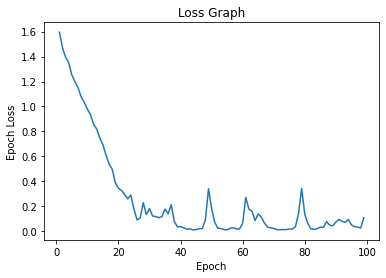

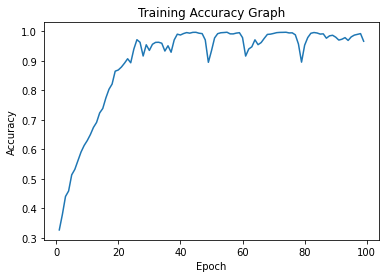

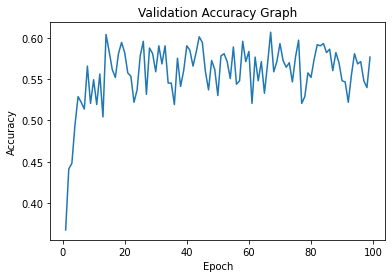

In [70]:
import numpy as np
plt.plot(np.arange(1,len(loss_log)+1),loss_log)
plt.title("Loss Graph")
plt.ylabel("Epoch Loss")
plt.xlabel("Epoch")
plt.show()
plt.plot(np.arange(1,len(train_acc_log)+1),train_acc_log)
plt.title("Training Accuracy Graph")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()
plt.plot(np.arange(1,len(eval_acc_log)+1),eval_acc_log)
plt.title("Validation Accuracy Graph")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()